# Statistical Learning HW5: Time Series Prediction

#### Time Series Prediction Problem
Time series prediction problem has a wide range of applications. We are going to explore this issue in this homework. To keep things simple, we are going to focus on the univariate time series, a time series with a single value in a period. 

#### Dataset: Weekly Product Sales
The dataset contains 104 weeks of training data and 39 weeks of test data. The time series is the product sales of a supermarket in a particular period. The goal is to predict sales in the test period. The training data is in "dep2train.csv" and the test data is in "dep2test.csv."

Below is the first few records of these two files:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =120
from datetime import datetime, date
import pandas as pd
dep2train = pd.read_csv('data/dep2train.csv')
print("Head of training data:")
print(dep2train.head())
dep2test = pd.read_csv('data/dep2test.csv')
print("Head of test data:")
print(dep2test.head())

Head of training data:
         date  weeklySales
0  2010-02-05    123952.48
1  2010-02-12    119209.48
2  2010-02-19    121430.80
3  2010-02-26    120292.15
4  2010-03-05    113163.91
Head of test data:
         date  weeklySales
0  2011-11-04    108655.66
1  2011-11-11    106841.49
2  2011-11-18     98341.91
3  2011-11-25     97213.06
4  2011-12-02     99976.34


Let's plot the training and test data.

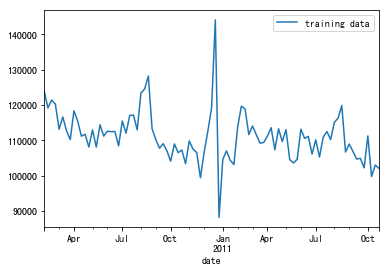

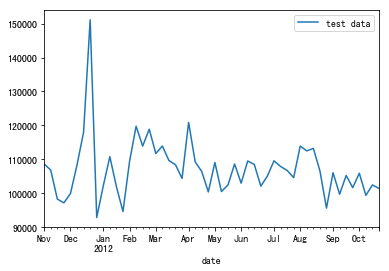

In [3]:
dep2train['date'] = pd.to_datetime(dep2train['date'])
dep2train['fold'] = 'train'
dep2test['date'] = pd.to_datetime(dep2test['date'])
dep2test['fold'] = 'test'

_ = dep2train.plot(y = 'weeklySales', x = 'date', label = 'training data')
_ = dep2test.plot(y = 'weeklySales', x = 'date', label = 'test data')

#### Measure of Prediction Accuracy
We are going to measure the prediction accuracy by mean absolute percentage error (MAPE). You should report MAPE using test data for every question. MAPE is defined as:
$ MAPE = \frac{1}{n} \sum_{i=1}^n |\frac{\hat{y}_t - y_t}{y_t}|,$ where $y_t$ is the actual value of period t and $\hat{y}_t$ is the prediction for period t. 

#### Train-test Split and Expanding Window
A common way to compute prediction error (MAPE) is to use a train-test split. We train a model M1 using the training data and use M1 to make predictions. When doing this, we apply the model and every test record independently and compute the MAPE. This approach, however, may not be reasonable because we can make predictions sequentially when applying to time series models. This is so-called the "Expanding Window" approach. That is, after making a prediction for period 1, we can include the data of period 1 into our training data. When making a prediction for period 2, the model can make use of data in period 1 together with the training data as well. We can optionally re-train the model after predicting for period 1. However, this often takes longer, and we do not re-train the model when making predictions in this homework. That is, when doing the Expanding Window approach, we train the model once using training data. To make predictions, we sequentially apply the model and include test data into training data after the test data point is used to make predictions. 

#### Implementation Restriction
You are allowed to use any Python libraries in your solution.

### Data Preprocessing

In [4]:
def get_week_numbers(dates):
    week_numbers = []
    for date in dates:
        week_number = date.isocalendar()[1]
        week_numbers.append(week_number)
    return pd.Series(week_numbers)

In [5]:
dep2train['week_number'] = get_week_numbers(dep2train['date'])
dep2train.head()

,date,weeklySales,fold,week_number
0,2010-02-05,123952.48,train,5
1,2010-02-12,119209.48,train,6
2,2010-02-19,121430.80,train,7
3,2010-02-26,120292.15,train,8
4,2010-03-05,113163.91,train,9


In [6]:
dep2test['week_number'] = get_week_numbers(dep2test['date'])
dep2test.head()

,date,weeklySales,fold,week_number
0,2011-11-04,108655.66,test,44
1,2011-11-11,106841.49,test,45
2,2011-11-18,98341.91,test,46
3,2011-11-25,97213.06,test,47
4,2011-12-02,99976.34,test,48


In [7]:
# MAPE
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Question 1 [Baseline]
(30%) Predict the sales of test data using the mean weekly sales of same week-of-year in training data. Adopt the standard train-test method to compute MAPE. For example to predict the weekly sales of 2011-11-04, we can use the sales records with similar "day of year" or "week of year" in 2010. Since 2011-11-04 is the 307-th day in 2011, you can use the 43-week (307//7) in year 2010 to predict the weekly sales of 2011-11-04. 

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value. 

In [7]:
dep2test_q1 = dep2test.copy()

In [8]:
predictions = []
for i in dep2test_q1['week_number']:
    sales_list = dep2train.loc[dep2train['week_number'] ==  i, 'weeklySales']
    prediction = sales_list.mean()
    predictions.append(prediction)
dep2test_q1['prediction'] = pd.Series(predictions)

In [9]:
dep2test_q1.head()

,date,weeklySales,fold,week_number,prediction
0,2011-11-04,108655.66,test,44,109861.57
1,2011-11-11,106841.49,test,45,107551.26
2,2011-11-18,98341.91,test,46,106610.62
3,2011-11-25,97213.06,test,47,99460.37
4,2011-12-02,99976.34,test,48,106702.70


### Q1 result

In [10]:
# MAPE
MAPE_q1 = mean_absolute_percentage_error(dep2test_q1['weeklySales'], dep2test_q1['prediction'])
print("Baseline MAPE: {}%".format(MAPE_q1))

Baseline MAPE: 4.359138717038288%


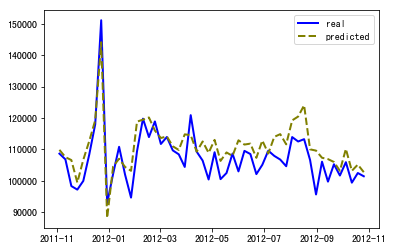

In [11]:
plt.plot('date', 'weeklySales', data= dep2test_q1, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction', data= dep2test_q1, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()

### Question 2 [Random Forest]
Preidct weekly sales using Random Forest (RF). Consider the two following setting. 
* Q2.1 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4})$. 
* Q2.2 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52})$. 

You should use the "Expanding Window" approach when evaluating the prediction accuracy. For each setting, report the MAPE and a plot of true and predicted values. 

In [12]:
dep2train.shape

(91, 4)

In [13]:
dep2test.shape

(52, 4)

In [14]:
from sklearn.ensemble import RandomForestRegressor
cols = ["y-1", "y-2", "y-3", "y-4", "y-52"]
pd_all = pd.concat([dep2train, dep2test], ignore_index=True)
pd_all = pd.concat([pd_all, pd.DataFrame(columns=cols)], ignore_index=True, sort=True)

In [17]:
pd_all.head()

,date,fold,week_number,weeklySales,y-1,y-2,y-3,y-4,y-52
0,2010-02-05,train,5.0,123952.48,NaN,NaN,NaN,NaN,NaN
1,2010-02-12,train,6.0,119209.48,NaN,NaN,NaN,NaN,NaN
2,2010-02-19,train,7.0,121430.80,NaN,NaN,NaN,NaN,NaN
3,2010-02-26,train,8.0,120292.15,NaN,NaN,NaN,NaN,NaN
4,2010-03-05,train,9.0,113163.91,NaN,NaN,NaN,NaN,NaN


In [18]:
sales_list = pd_all["weeklySales"].tolist()
for i in range(len(sales_list)):
    try:
        pd_all.iloc[i, 4:8] = pd_all.iloc[i-4:i]['weeklySales'].values
    except:
        pass

    i_y_52 = i - 52
    if i_y_52 >= 0:
        pd_all.at[i, 'y-52'] = pd_all.iloc[i_y_52]['weeklySales']

In [19]:
pd_all.head(10)

,date,fold,week_number,weeklySales,y-1,y-2,y-3,y-4,y-52
0,2010-02-05,train,5.0,123952.48,NaN,NaN,NaN,NaN,NaN
1,2010-02-12,train,6.0,119209.48,NaN,NaN,NaN,NaN,NaN
2,2010-02-19,train,7.0,121430.80,NaN,NaN,NaN,NaN,NaN
3,2010-02-26,train,8.0,120292.15,NaN,NaN,NaN,NaN,NaN
4,2010-03-05,train,9.0,113163.91,123952,119209,121431,120292,NaN
5,2010-03-12,train,10.0,116637.87,119209,121431,120292,113164,NaN
6,2010-03-19,train,11.0,112732.09,121431,120292,113164,116638,NaN
7,2010-03-26,train,12.0,110240.07,120292,113164,116638,112732,NaN
8,2010-04-02,train,13.0,118392.02,113164,116638,112732,110240,NaN
9,2010-04-09,train,14.0,115461.31,116638,112732,110240,118392,NaN


In [20]:
pd_all[50:60]

,date,fold,week_number,weeklySales,y-1,y-2,y-3,y-4,y-52
50,2011-01-21,train,3.0,104415.90,144104,88211.6,104581,107043,NaN
51,2011-01-28,train,4.0,103200.60,88211.6,104581,107043,104416,NaN
52,2011-02-04,train,5.0,113720.83,104581,107043,104416,103201,123952
53,2011-02-11,train,6.0,119715.02,107043,104416,103201,113721,119209
54,2011-02-18,train,7.0,118892.18,104416,103201,113721,119715,121431
55,2011-02-25,train,8.0,111673.55,103201,113721,119715,118892,120292
56,2011-03-04,train,9.0,114097.02,113721,119715,118892,111674,113164
57,2011-03-11,train,10.0,111658.47,119715,118892,111674,114097,116638
58,2011-03-18,train,11.0,109251.87,118892,111674,114097,111658,112732
59,2011-03-25,train,12.0,109417.20,111674,114097,111658,109252,110240


In [21]:
train_RF = pd_all.head(91)
test_RF = pd_all.tail(52).reset_index(drop=True)

In [22]:
train_RF.shape

(91, 9)

In [23]:
test_RF.shape

(52, 9)

### Q2.1

In [28]:
train_remove = train_RF[pd.notnull(train_RF['y-1'])]
X_FR1 = train_remove.iloc[:,4:8]
y_FR1 = train_remove.iloc[:,3]

test_remove = test_RF[pd.notnull(test_RF['y-1'])]
X_FR1_test = test_remove.iloc[:,4:8]

In [29]:
forest = RandomForestRegressor()
forest_fit = forest.fit(X_FR1, y_FR1)
predictions_RF1 = forest_fit.predict(X_FR1_test)
test_RF['prediction'] = predictions_RF1

In [30]:
test_RF.head()

,date,fold,week_number,weeklySales,y-1,y-2,y-3,y-4,y-52,prediction
0,2011-11-04,test,44.0,108655.66,111280,99815.1,103050,102098,109862,111218.039
1,2011-11-11,test,45.0,106841.49,99815.1,103050,102098,108656,107551,106741.238
2,2011-11-18,test,46.0,98341.91,103050,102098,108656,106841,106611,101460.552
3,2011-11-25,test,47.0,97213.06,102098,108656,106841,98341.9,99460.4,102062.605
4,2011-12-02,test,48.0,99976.34,108656,106841,98341.9,97213.1,106703,110281.023


### Q2.1 result

In [31]:
# MAPE
MAPE_q21 = mean_absolute_percentage_error(test_RF['weeklySales'], predictions_RF1)
print("(Q2.1) Random Forest: {}%".format(MAPE_q21))

(Q2.1) Random Forest: 5.4558252813626%


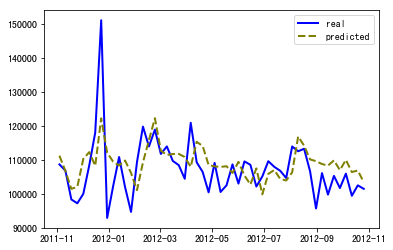

In [32]:
plt.plot('date', 'weeklySales', data= test_RF, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction', data= test_RF, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()

### Q2.2

In [33]:
train_remove = train_RF[pd.notnull(train_RF['y-52'])]
X_FR2 = train_remove.iloc[:,4:9]
y_FR2 = train_remove.iloc[:,3]
test_remove = test_RF[pd.notnull(test_RF['y-52'])]
X_FR2_test = test_remove.iloc[:,4:9]

In [34]:
forest2 = RandomForestRegressor()
forest_fit2 = forest2.fit(X_FR2, y_FR2)
predictions_RF2 = forest_fit2.predict(X_FR2_test)
test_RF['prediction2'] = predictions_RF2

In [35]:
test_RF.head()

,date,fold,week_number,weeklySales,y-1,y-2,y-3,y-4,y-52,prediction,prediction2
0,2011-11-04,test,44.0,108655.66,111280,99815.1,103050,102098,109862,111218.039,105974.070
1,2011-11-11,test,45.0,106841.49,99815.1,103050,102098,108656,107551,106741.238,102180.406
2,2011-11-18,test,46.0,98341.91,103050,102098,108656,106841,106611,101460.552,102549.904
3,2011-11-25,test,47.0,97213.06,102098,108656,106841,98341.9,99460.4,102062.605,103110.919
4,2011-12-02,test,48.0,99976.34,108656,106841,98341.9,97213.1,106703,110281.023,102458.501


### Q2.2 result

In [37]:
# MAPE
MAPE_q22 = mean_absolute_percentage_error(test_RF['weeklySales'], predictions_RF2)
print("(Q2.2) Random Forest: {}%".format(MAPE_q22))

(Q2.2) Random Forest: 3.6922028477925113%


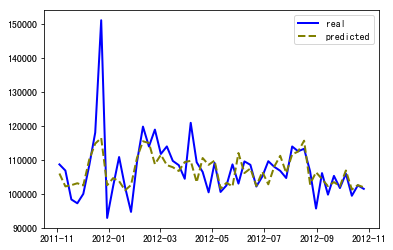

In [38]:
plt.plot('date', 'weeklySales', data= test_RF, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction2', data= test_RF, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()

### Question 3 [Gaussian Process Regression]
Gaussian process regression (GPR) can be used to perform time series prediction. The input feature is simply the "week sequence number." You can construct this week sequence number from the calendar date.  Each week sequence number is paired with its weekly sales. Your Gaussian process regression should have a kernel that contains the sum of an RBF kernel (sklearn.gaussian_process.kernels.RBF), an Exp-Sine-Squared kernel (sklearn.gaussian_process.kernels.ExpSineSquared), and a White noise kernel (sklearn.gaussian_process.kernels.WhiteKernel). The RBF kernel is used to capture near-by relations, the Exp-Sine-Squared kernel is used to capture seasonality, and the White noise kernel is used to model noise. 

* Q3.1 (20%) Normalize the weekly sales using training data so that the training data for GPR have a mean 0 and unit variance, and the test data also have a mean close to zero and a variance close to one. Train your model and make predictions. Be sure to transform the prediction data back to the original scale before computing MAPE. 
* Q3.2 (20%) Repeat Q3.1 but use the original weekly sales instead of the transformed values. 
* Q3.3 (20%) Selected the best model from Q3.1 and Q3.2. Use this model to perform "Expanding Window" approach and compute MAPE. Note that you should do retrain but set the solver to none so that you do not need to reestimate the kernel parameters. 

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value for each of the sub-question. 

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
from sklearn import preprocessing
test_q3 = dep2test.copy()
train_q3 = dep2train.copy()

In [31]:
def reshape_arr(feature):
    arr = np.array(feature).reshape((len(feature), 1))
    return arr

In [32]:
#standardize feature values
xscaler = preprocessing.StandardScaler().fit(reshape_arr(train_q3["weeklySales"]))
train_q3['nor_sales'] = xscaler.transform(reshape_arr(train_q3["weeklySales"]))
test_q3['nor_sales'] = xscaler.transform(reshape_arr(test_q3["weeklySales"]))

### Q3.1

In [33]:
kernels = (RBF() + ExpSineSquared() + WhiteKernel())
gaussian = GaussianProcessRegressor(kernel = kernels)
gaussian_fit = gaussian.fit(reshape_arr(train_q3['week_number']), train_q3['nor_sales'])
predictions_GPR1 = gaussian_fit.predict(reshape_arr(test_q3['week_number']))
predictions_GPR1 = xscaler.inverse_transform(predictions_GPR1)
test_q3['prediction'] = predictions_GPR1

In [34]:
test_q3.head()

,date,weeklySales,fold,week_number,nor_sales,prediction
0,2011-11-04,108655.66,test,44,-0.362811,109592.291447
1,2011-11-11,106841.49,test,45,-0.620601,107790.801859
2,2011-11-18,98341.91,test,46,-1.828373,106740.930138
3,2011-11-25,97213.06,test,47,-1.988780,101421.438969
4,2011-12-02,99976.34,test,48,-1.596124,107391.104423


### Q3.1 result

In [36]:
MAPE_q31 = mean_absolute_percentage_error(test_q3['weeklySales'], predictions_GPR1)
# MAPE
print("(Q3.1) Gaussian process: {}%".format(MAPE_q31))

(Q3.1) Gaussian process: 4.486291984859118%


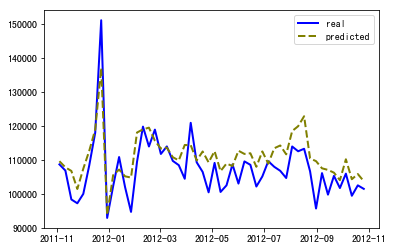

In [47]:
plt.plot('date', 'weeklySales', data= test_q3, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction', data= test_q3, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()

### Q3.2

In [37]:
gaussian1_fit2 = gaussian.fit(reshape_arr(train_q3['week_number']), train_q3['weeklySales'])
predictions_GPR2 = gaussian1_fit2.predict(reshape_arr(test_q3['week_number']))
test_q3['prediction2'] = predictions_GPR2

In [38]:
test_q3.head()

,date,weeklySales,fold,week_number,nor_sales,prediction,prediction2
0,2011-11-04,108655.66,test,44,-0.362811,109592.291447,202.032511
1,2011-11-11,106841.49,test,45,-0.620601,107790.801859,202.032510
2,2011-11-18,98341.91,test,46,-1.828373,106740.930138,202.032510
3,2011-11-25,97213.06,test,47,-1.988780,101421.438969,202.032510
4,2011-12-02,99976.34,test,48,-1.596124,107391.104423,202.032510


### Q3.2 result

In [39]:
MAPE_q32 = mean_absolute_percentage_error(test_q3['weeklySales'], predictions_GPR2)
# MAPE
print("(Q3.2) Gaussian process: {}%".format(MAPE_q32))

(Q3.2) Gaussian process: 99.81066552709889%


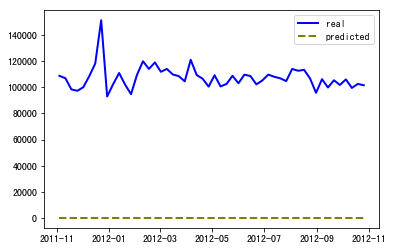

In [40]:
plt.plot('date', 'weeklySales', data= test_q3, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction2', data= test_q3, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()

### Q3.3

Q3.3 (20%) Selected the best model from Q3.1 and Q3.2. Use this model to perform "Expanding Window" approach and compute MAPE. Note that you should do retrain but set the solver to none so that you do not need to reestimate the kernel parameters.

In [41]:
cols = ["prediction3"]
test_q3 = pd.concat([test_q3, pd.DataFrame(columns=cols)], ignore_index=True, sort=True)

In [42]:
kernels3 = (RBF() + ExpSineSquared() + WhiteKernel())
gaussian3 = GaussianProcessRegressor(kernel = kernels3, optimizer=None)

In [43]:
X_GPR3 = train_q3['week_number']
y_GPR3 = train_q3['nor_sales']
gaussian_fit3 = gaussian3.fit(reshape_arr(X_GPR3), y_GPR3)
for i in range(len(test_q3)):
    if i > 1:
        X_GPR3 = X_GPR3.append(pd.Series([test_q3['week_number'][i-1]]))
        y_GPR3 = y_GPR3.append(pd.Series([test_q3['nor_sales'][i-1]]))
    
    gaussian_fit3 = gaussian3.fit(reshape_arr(X_GPR3), y_GPR3)
    week = test_q3['week_number'][i]
    predictions_GPR3 = gaussian_fit3.predict(reshape_arr(pd.Series([week])))
    prediction3 = xscaler.inverse_transform(predictions_GPR3)
    test_q3.loc[i, 'prediction3'] = prediction3

### Q3.3 result

In [44]:
MAPE_q33 = mean_absolute_percentage_error(test_q3['weeklySales'], test_q3['prediction3'])
# MAPE
print("(Q3.3) Gaussian process: {}%".format(MAPE_q33))

(Q3.3) Gaussian process: 4.958710950175156%


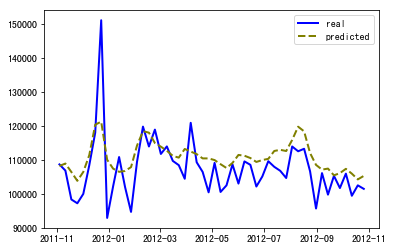

In [45]:
plt.plot('date', 'weeklySales', data= test_q3, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction3', data= test_q3, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()

### Question 4 [Summarize and Discuss]
(10%) Summarize the prediction performance and discuss your findings. 

* 由Q1可知，用歷史相對應時間的銷售額作為預測金額，效果很好，也顯示了銷售額的週期性
* Q2.1僅用和預測時間相近的四期資料，能捕捉近期的關係，但少了季節性的特徵
* Q2.2納入一年前同期資料後，MAPE明顯下降，並低於Baseline，預測效果最好
* 使用Gaussian process做預測，要將銷售額標準化後才有預測效果
* 使用Gaussian process做時間序列預測，需透過不同Kernel來捕捉趨勢和降低干擾
* 在Gaussian proces方法下，使用expanding window作法，並沒有有效降低MAPE

### Bonus Question 5 [My Prediction Model]
(20%) This is a bonus question. Develop your own method. Your method should be different from the methods in Questions 1 to 3. Moreover, your method should deliver a MAPE that is better than the baseline model. 

In [8]:
test_q5 = dep2test.copy()

In [27]:
predictions = []
for i in test_q5['week_number']:
    sales_list = dep2train.loc[dep2train['week_number'] ==  i, 'weeklySales']
    prediction = sales_list.iloc[-1]
    predictions.append(prediction)
test_q5['prediction'] = pd.Series(predictions)

In [28]:
# MAPE
MAPE_q5 = mean_absolute_percentage_error(test_q5['weeklySales'], test_q5['prediction'])
print("Bonus MAPE: {}%".format(MAPE_q5))

Bonus MAPE: 3.657097713947293%


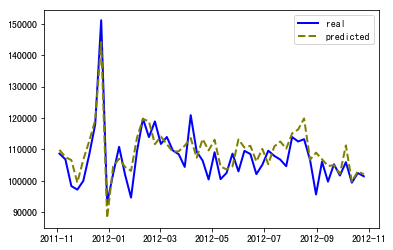

In [29]:
plt.plot('date', 'weeklySales', data= test_q5, marker='', color='blue', linewidth=2, label="real")
plt.plot('date', 'prediction', data= test_q5, marker='', color='olive', linewidth=2, linestyle='dashed', label="predicted")
plt.legend()